In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
images_path = "/content/images"
test_path = "/content/TEST"

import os

# Check contents
print("Images folder contents:", os.listdir(images_path)[:5])
print("TEST folder contents:", os.listdir(test_path)[:5])


Images folder contents: ['N38.xml', 'N202.jpeg', 'N193.xml', 'N5.jpeg', 'N112.xml']
TEST folder contents: ['TEST.jpeg', 'TEST.mp4']


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from albumentations import Compose, BboxParams, Resize, HorizontalFlip, RandomBrightnessContrast, Normalize
from albumentations.pytorch import ToTensorV2

### Define the Dataset Class

In [ ]:
class ANPRDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, transforms=None):
        self.annotations = annotations
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path, bboxes, labels = self.annotations[idx]

        # Open the image using PIL's Image
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert to numpy array

        # Apply transformations if any
        if self.transforms:
            augmented = self.transforms(image=image, bboxes=bboxes, labels=labels)
            image = augmented['image']
            bboxes = augmented['bboxes']
            labels = augmented['labels']

        # Convert bounding boxes and labels to tensor format
        target = {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),  # Bounding boxes
            'labels': torch.tensor(labels, dtype=torch.int64)     # Class labels
        }

        return image, target

    def __len__(self):
        # Return the length of the annotations list
        return len(self.annotations)


In [ ]:


class ANPRDataset(Dataset):
    def __init__(self, annotations, transforms=None):
        self.annotations = annotations
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_path, boxes, labels = self.annotations[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = {'boxes': torch.tensor(boxes, dtype=torch.float32),
                  'labels': torch.tensor(labels, dtype=torch.int64)}

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)

        return image, target


### Data Preprocessing and Augmentation

In [ ]:
def get_transforms(train=True):
    if train:
        return Compose([
            Resize(512, 512),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], bbox_params=BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return Compose([
            Resize(512, 512),
            Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], bbox_params=BboxParams(format='pascal_voc', label_fields=['labels']))


### Create Annotation

In [ ]:
import os
import xml.etree.ElementTree as ET

# Paths to your image and annotation directories
images_dir = '/content/images'
annotations_dir = '/content/images'

# Initialize the annotations list
annotations = []

# Iterate through all .xml files in the annotations directory
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        # Parse the XML file
        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get the image file name from the XML
        image_file = root.find('filename').text
        image_path = os.path.join(images_dir, image_file)

        # Initialize bounding boxes and labels
        boxes = []
        labels = []

        # Extract bounding box and label information
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            x_min = int(bbox.find('xmin').text)
            y_min = int(bbox.find('ymin').text)
            x_max = int(bbox.find('xmax').text)
            y_max = int(bbox.find('ymax').text)
            boxes.append([x_min, y_min, x_max, y_max])

            # For now, assume a single class label for license plates
            labels.append(1)

        # Append the annotation for this image
        annotations.append((image_path, boxes, labels))

# Print the first few annotations to verify
print(f"Total annotations: {len(annotations)}")
print(annotations[:5])  # Print first 5 annotations to check


Total annotations: 225
[('/content/images/N38.jpeg', [[397, 590, 645, 641]], [1]), ('/content/images/N193.jpeg', [[274, 2, 502, 59]], [1]), ('/content/images/N112.jpeg', [[179, 256, 347, 290]], [1]), ('/content/images/N218.jpeg', [[176, 212, 301, 238]], [1]), ('/content/images/N73.jpeg', [[124, 102, 209, 130]], [1])]


### Visualize Annotations

Visualizing: /content/images/N38.jpeg


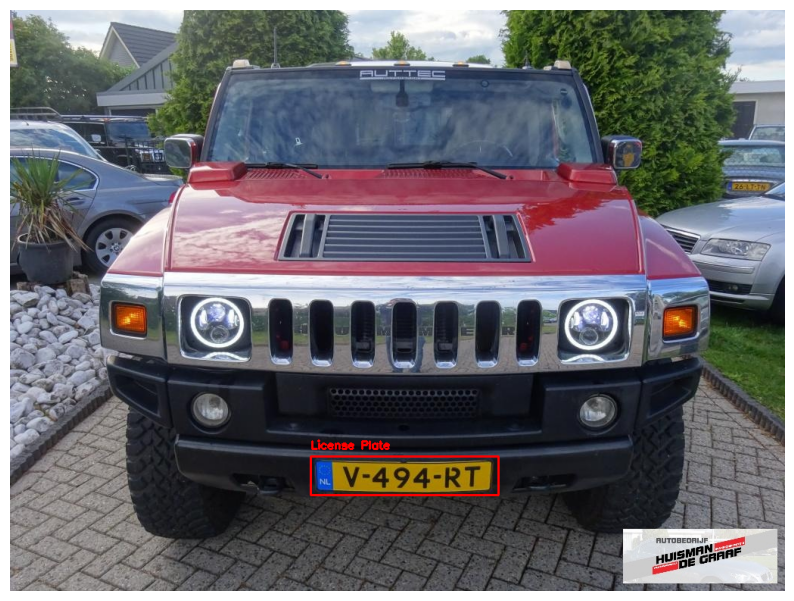

Visualizing: /content/images/N193.jpeg


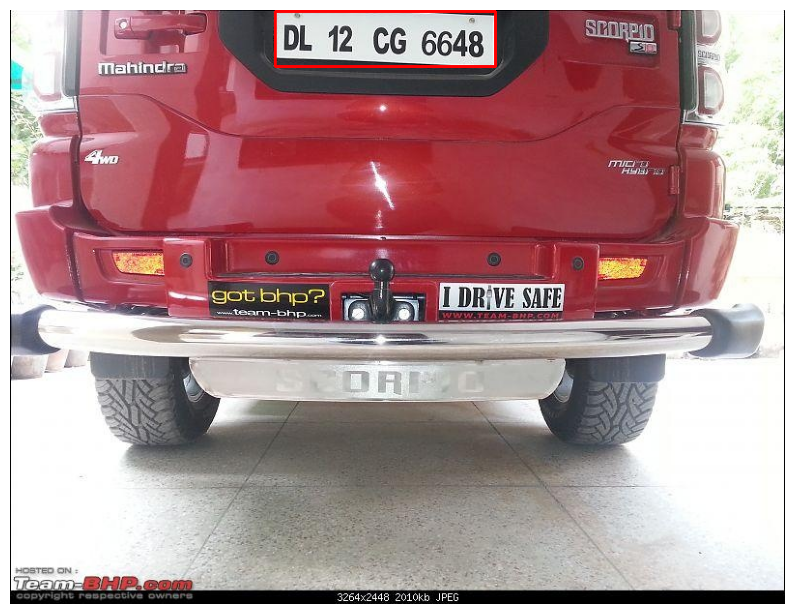

Visualizing: /content/images/N112.jpeg


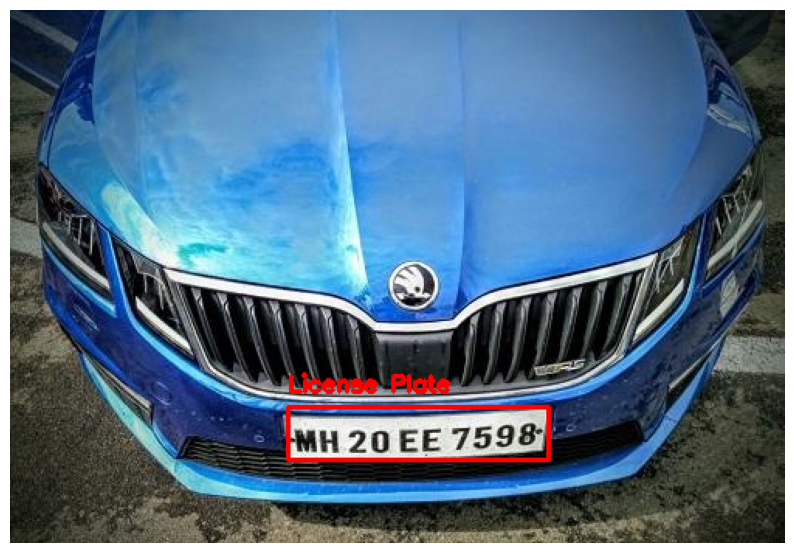

Visualizing: /content/images/N218.jpeg


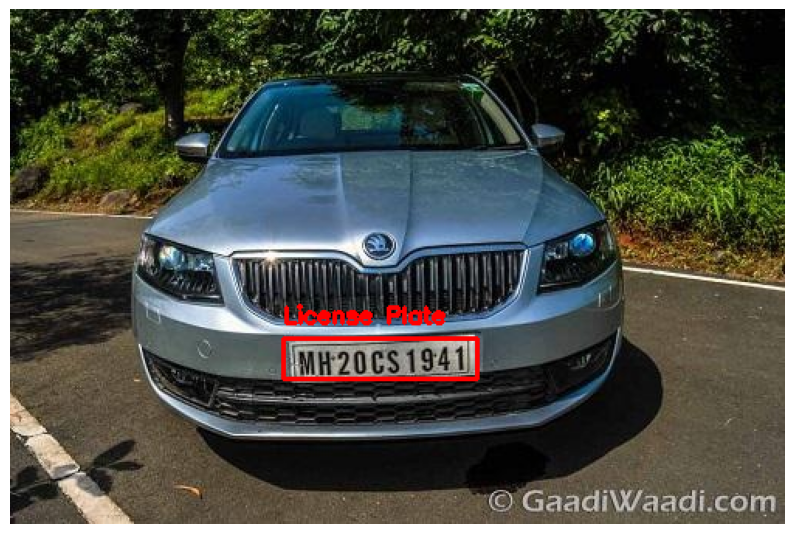

Visualizing: /content/images/N73.jpeg


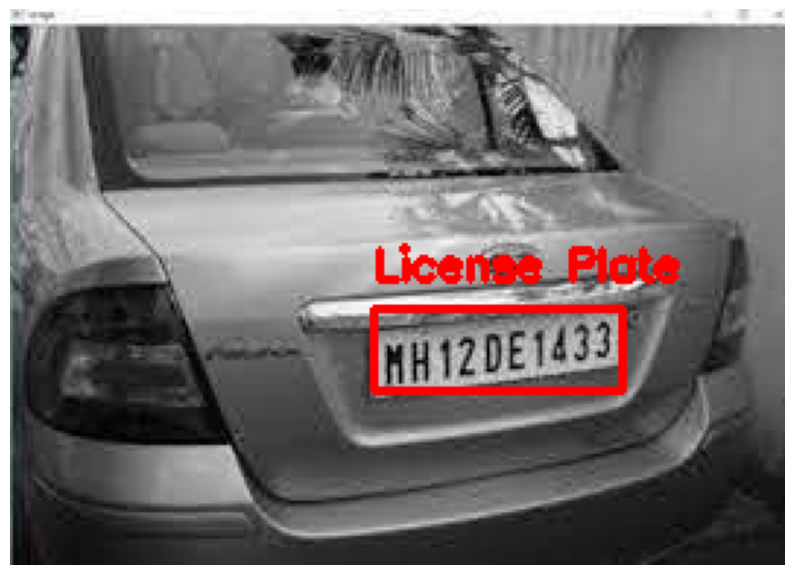

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Function to visualize a single annotation
def visualize_annotation(image_path, boxes, labels):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Draw each bounding box on the image
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue rectangle

        # Optionally add label text (assuming all labels are 'License Plate')
        label = "License Plate"
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize a few examples
for i, (image_path, boxes, labels) in enumerate(annotations[:5]):  # Adjust the range as needed
    print(f"Visualizing: {image_path}")
    visualize_annotation(image_path, boxes, labels)


# Model [Fast R-CNN]

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# 1. Model Initialization
model = fasterrcnn_resnet50_fpn(pretrained=True)  # Load a pre-trained Fast R-CNN model with a ResNet-50 backbone

# Modify the classifier (if needed, e.g., for different number of classes)
num_classes = 10  # for example: background + 9 object classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# 2. Move Model to Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3. Define Optimizer and Scheduler (If needed)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 4. Load Data (DataLoader for train/validation datasets)




### Load Dataset Annotations

In [ ]:
import os
import xml.etree.ElementTree as ET

# Paths to your image and annotation directories
images_dir = '/content/images'  # Replace with your actual images directory
annotations_dir = '/content/images'  # Replace with your annotations directory

# Initialize the annotations list
annotations = []

# Iterate through all .xml files in the annotations directory
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        # Parse the XML file
        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get the image file name from the XML
        image_file = root.find('filename').text
        image_path = os.path.join(images_dir, image_file)

        # Initialize bounding boxes and labels
        boxes = []
        labels = []

        # Extract bounding box and label information
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            x_min = int(bbox.find('xmin').text)
            y_min = int(bbox.find('ymin').text)
            x_max = int(bbox.find('xmax').text)
            y_max = int(bbox.find('ymax').text)
            boxes.append([x_min, y_min, x_max, y_max])

            # For now, assume a single class label for license plates
            labels.append(1)

        # Append the annotation for this image
        annotations.append((image_path, boxes, labels))

# Split the dataset into training and validation sets
split = int(0.8 * len(annotations))
train_annotations = annotations[:split]
val_annotations = annotations[split:]

# Assuming you have already implemented the `ANPRDataset` and `get_transforms`
train_dataset = ANPRDataset(train_annotations, get_transforms(train=True))
val_dataset = ANPRDataset(val_annotations, get_transforms(train=False))

# Print dataset information for verification
print(f"Total annotations: {len(annotations)}")
print(f"Training annotations: {len(train_annotations)}")
print(f"Validation annotations: {len(val_annotations)}")


Total annotations: 225
Training annotations: 180
Validation annotations: 45


### Load Pre-Trained Model

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 2  # 1 (license plate) + 1 (background)
model = get_model(num_classes)


### Training

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(num_epochs, train_data, val_data, model, optimizer, scheduler, device):
    model.to(device)
    train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_data, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, targets in train_data:
           # Move images and targets to device
           images = [image.to(device) for image in images]
           targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

           # Zero out gradients
           optimizer.zero_grad()

          # Forward pass through the model
           loss_dict = model(images, targets)

          # Total loss (sum of all losses)
           losses = sum(loss for loss in loss_dict.values())

          # Backward pass and optimization
           losses.backward()
           optimizer.step()


        scheduler.step()

        print(f"Epoch {epoch+1} Loss: {train_loss / len(train_loader):.4f}")


### Save and Evaluate

Evaluate Model


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from PIL import Image

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    iou_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Inspect batch contents (labels and other fields)
            print(targets)  # This will help to debug the data format

            # Perform inference
            predictions = model(images)

            # Compute IoU (Intersection over Union) or other metrics
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes']
                target_boxes = target['boxes']

                # Assuming 'box_iou' calculates IoU between predicted and ground truth boxes
                iou = box_iou(pred_boxes, target_boxes)
                iou_scores.append(iou.mean().item())

    print(f"Mean IoU: {sum(iou_scores) / len(iou_scores):.4f}")


 Model Inference

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Set the model to evaluation mode
model.eval()

# For inference on a single image
def infer_image(image_path):
    """
    Perform inference on a single image.

    Args:
    - image_path (str): Path to the input image.

    Returns:
    - prediction: The model's prediction for the input image.
    """
    # Open image
    image = Image.open(image_path).convert("RGB")

    # Define transformation
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Transform the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():  # No need to track gradients during inference
        prediction = model(image)
    return prediction

# Image inference
image_path = '/content/TEST/TEST.jpeg'
image_prediction = infer_image(image_path)
print("Image Prediction:", image_prediction)


Image Prediction: [{'boxes': tensor([[4.4534e-01, 4.0315e+02, 9.5470e+00, 4.1777e+02],
        [8.7562e-01, 3.9828e+02, 1.0062e+01, 4.1362e+02],
        [2.0787e+00, 3.9083e+02, 1.0499e+01, 4.0631e+02],
        [3.1304e+00, 3.8648e+02, 1.0630e+01, 4.0062e+02],
        [2.7348e+00, 3.8776e+02, 1.2792e+01, 4.2337e+02],
        [0.0000e+00, 4.0820e+02, 8.5289e+00, 4.2542e+02],
        [4.7497e+00, 3.8947e+02, 1.1739e+01, 4.0331e+02],
        [2.5356e+00, 4.0095e+02, 1.1510e+01, 4.3190e+02],
        [3.2120e+00, 3.7808e+02, 1.1939e+01, 4.0606e+02],
        [2.8754e+00, 3.6858e+02, 1.1069e+01, 3.9581e+02],
        [4.9734e+00, 3.9291e+02, 1.5230e+01, 4.1063e+02],
        [8.9316e+01, 3.6364e+02, 9.2539e+01, 3.7216e+02],
        [4.1767e+00, 2.5135e+02, 1.3887e+01, 2.8572e+02],
        [2.6761e+02, 5.2165e+02, 2.7551e+02, 5.3685e+02],
        [0.0000e+00, 4.0319e+02, 4.3507e+00, 4.2287e+02],
        [8.8992e+01, 3.6592e+02, 9.3716e+01, 3.7559e+02],
        [3.3745e+00, 3.7131e+02, 1.6819e+01

Save Model

In [ ]:
torch.save(model.state_dict(), "faster_rcnn_anpr.pth")


Image Tensor Shape

In [ ]:
import numpy as np
import torch
from PIL import Image

# Load the image
image_path = '/content/TEST/TEST.jpeg'
image = Image.open(image_path)

# Convert the image to a NumPy array
image_np = np.array(image)

# Convert the NumPy array to a PyTorch tensor
image_tensor = torch.tensor(image_np)

print(f"Image tensor shape: {image_tensor.shape}")


Image tensor shape: torch.Size([729, 901, 3])


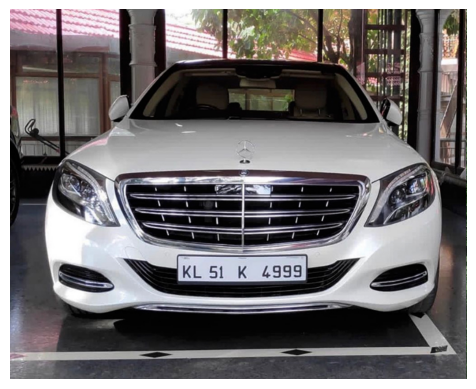

Image tensor shape: torch.Size([3, 729, 901])


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Load your image
image_path = '/content/TEST/TEST.jpeg'

image = Image.open(image_path)

# 2. Convert the image to a PyTorch tensor using transforms
transform = transforms.ToTensor()  # Convert the image to a tensor
image_tensor = transform(image)

# 3. Display the image using matplotlib
# To display with matplotlib, convert the tensor back to a numpy array
image_np = image_tensor.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC for matplotlib
plt.imshow(image_np)
plt.axis('off')  # Hide axis
plt.show()

# 4. Verify the tensor shape (optional)
print(f"Image tensor shape: {image_tensor.shape}")


### Evaluate Model Performance

In [ ]:
print(f"Image Path: {image_path}")
image_prediction = infer_image(image_path)
print("Image Prediction:", image_prediction)


Image Path: /content/TEST/TEST.jpeg
Image Prediction: [{'boxes': tensor([[ 85.8118, 376.5980,  91.5775, 387.5573],
        [650.1591, 108.3794, 661.8528, 126.7835],
        [ 86.8462, 378.3128,  94.6331, 391.3705],
        [ 86.0332, 381.4806,  91.7349, 391.9340],
        [ 83.6161, 506.3032, 606.2076, 667.7581],
        [292.0741, 497.5518, 811.2188, 672.3708],
        [779.5989,  69.3364, 783.7982,  86.8764],
        [330.3188, 289.1341, 829.2455, 484.5859],
        [ 89.5725, 382.1918,  99.4694, 395.6419],
        [403.7638, 333.1791, 415.7279, 340.2002],
        [779.0285,  70.7545, 782.2103,  84.8691],
        [136.8020, 534.8909, 752.8900, 701.9550],
        [102.4303, 391.9862, 111.6260, 405.3052],
        [ 96.5221, 387.1867, 106.2534, 402.1852],
        [131.2841, 296.5345, 674.4006, 469.6046],
        [ 92.7729, 383.4288, 103.1995, 399.2445],
        [638.2946, 102.7439, 670.6938, 137.6759],
        [361.0078, 552.4071, 884.5214, 725.7908],
        [ 99.7433, 296.8589, 109.04